# Quantum System: Estimator QNN

The code below implements a standard EstimatorQNN for Quantum Neural Networks. Similar to the Logistic Regression algorthm for classical Neural Networks, the EstimtorQNN is used to classify binary data that is seperable into one dimensional outputs.

In [1]:
!pip install qiskit_machine_learning
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile
from qiskit.visualization import *
from ibm_quantum_widgets import *

# qiskit-ibmq-provider has been deprecated.
# Please see the Migration Guides in https://ibm.biz/provider_migration_guide for more detail.
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Estimator, Session, Options

# Loading your IBM Quantum account(s)
service = QiskitRuntimeService(channel="ibm_quantum")

# Invoke a primitive. For more details see https://docs.quantum.ibm.com/run/primitives
# result = Sampler().run(circuits).result()
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import clear_output
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit_algorithms.optimizers import COBYLA, L_BFGS_B
from qiskit_algorithms.utils import algorithm_globals

from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC
from qiskit_machine_learning.algorithms.regressors import NeuralNetworkRegressor, VQR
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN
from qiskit_machine_learning.circuit.library import QNNCircuit

algorithm_globals.random_seed = 42

qiskit_runtime_service.__init__:INFO:2024-04-15 23:23:34,270: Default instance: ibm-q-education/uni-pittsburgh-1/phys-1470
/opt/conda/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/opt/conda/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


## Preparing Data

Unlike a classical system, a quantum system requires it's data to be prepared into a quantum state before use. However this can provide a problem for QNNs operating with classical data. One work around is to prepare the classical data into a quantum counter part by using gates or other methods. The method shown below uses amplitude encoding to turn classical data into aplitude vectors.

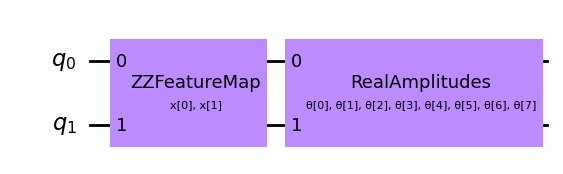

In [3]:
dataset = pd.read_csv('Social_Network_Ads.csv')
X = dataset.iloc[:, :-1].values
y = dataset.iloc[:, -1].values

# construct QNN with the QNNCircuit's default ZZFeatureMap feature map and RealAmplitudes ansatz.
qc = QNNCircuit(num_qubits=2)
qc.draw("mpl", style="clifford")

In [25]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)
print(X_train[:4])
print(y_train[:4])
print(X_test[:4])
print(y_test[:4])

[[    44  39000]
 [    32 120000]
 [    38  50000]
 [    32 135000]]
[0 1 0 1]
[[   30 87000]
 [   38 50000]
 [   35 75000]
 [   30 79000]]
[0 0 0 0]


In [29]:
estimator_qnn = EstimatorQNN(circuit=qc)

In [30]:
# callback function that draws a live plot when the .fit() method is called
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [31]:
# construct neural network classifier
estimator_classifier = NeuralNetworkClassifier(
    estimator_qnn, optimizer=COBYLA(maxiter=60), callback=callback_graph
)

## Optimization

The graph below shows the optimization of the QNN classifier as repeated iteration brings it closer to an objective function that accuractly sorts the data

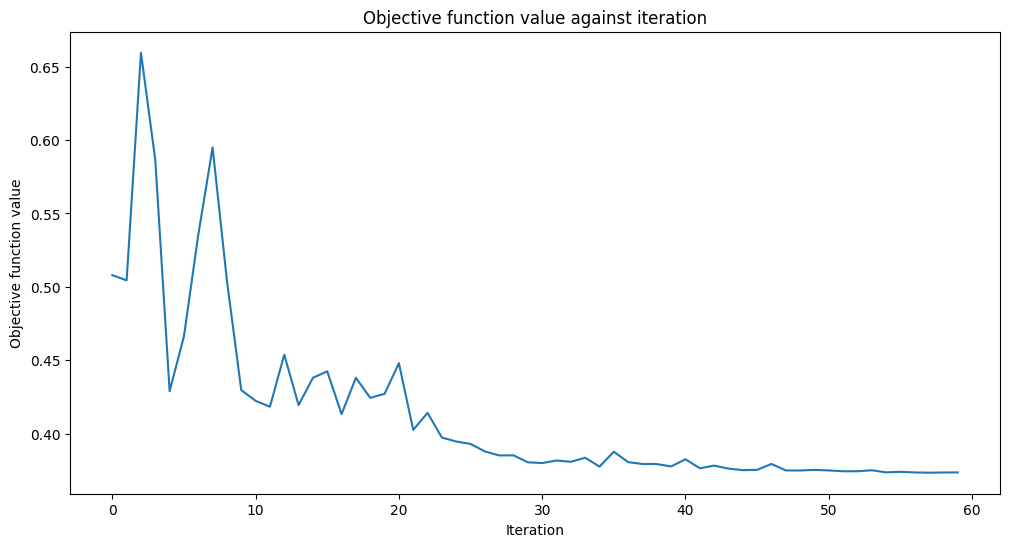

0.2675

In [32]:
# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit classifier to data
estimator_classifier.fit(X_train, y_train)

# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

# score classifier
estimator_classifier.score(X, y)

# Results

The below figure represents the data points as the output, and the misclassified data from the QNN is shown with red circles. Here we can see the data is not immediately linearly separable, and as such it is more challenging for the QNN to create a linear decision boundary. As such, the QNN struggles in this classification task.

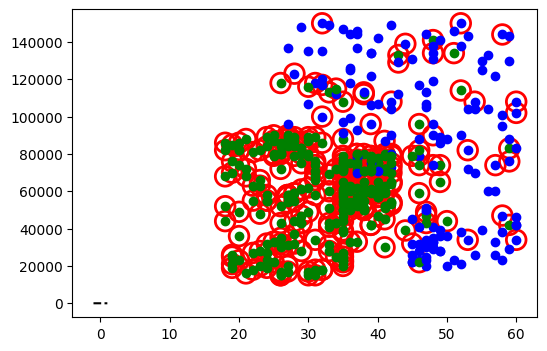

In [14]:
# evaluate data points
y_predict = estimator_classifier.predict(X_test)

# plot results
# red == wrongly classified
for x, y_target, y_p in zip(X, y_test, y_predict):
    if y_target == 1:
        plt.plot(x[0], x[1], "bo")
    else:
        plt.plot(x[0], x[1], "go")
    if y_target != y_p:
        plt.scatter(x[0], x[1], s=200, facecolors="none", edgecolors="r", linewidths=2)
plt.plot([-1, 1], [1, -1], "--", color="black")
plt.show()

In [17]:
estimator_classifier.weights

array([ 1.61756227, -0.20305845,  0.0953015 ,  0.97974636,  1.84005627,
       -0.56894895,  0.01287557, -0.13533646])

The figure below shows a confustion matrix represention of the output where it only correctly identified 32 data points out of the total 100 test data points meaning an accuracy of 32%

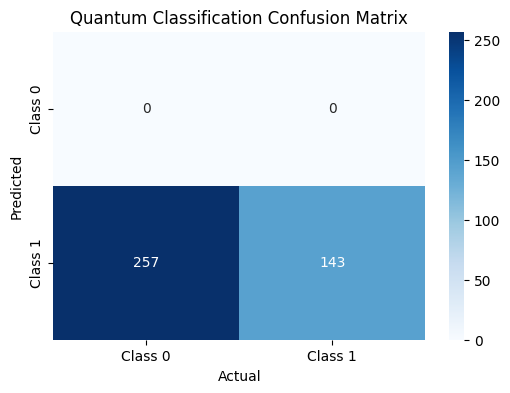

In [33]:
import numpy as np
import seaborn as sns

conf_matrix = np.zeros((2, 2))
for pred, target in zip(y_predict, y):
    conf_matrix[int(pred[0])][target] += 1
    
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="g", xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Quantum Classification Confusion Matrix')
# plt.show()
plt.savefig('qc_cm.png', dpi=600)